### DLモデル　改訂版

In [3]:
# PDF印刷用
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'fig-10-'

def create_pdf():
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.rcParams['figure.subplot.bottom'] = 0.15
    plt.rcParams['figure.subplot.left'] = 0.15
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

<a href="https://colab.research.google.com/github/makaishi2/dl-math-v2-doc/blob/main/sample-notebook/ch10_new.ipynb" target="_parent"><img src="https://colab.
research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 必要ライブラリの導入

In [4]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 56.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
# 共通事前処理

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# Numpyで浮動小数点表示を固定する
np.set_printoptions(formatter={'float': '{:0.3f}'.format})

# データフレーム表示用関数
from IPython.display import display

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.3f}'.format

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

## 10-7 プログラム実装(データ準備・加工)

### データ読み込み

#### 読み込み

In [6]:
# データ読み込み

# データ読み込み用ライブラリのインポート
from torchvision.datasets import MNIST
from torchvision import transforms

# 訓練データ
train_dataset = MNIST(root="./data", train=True, download=True)

# テストデータ
test_dataset = MNIST(root="./data", train=False, download=True)

# NumPy 配列に変換
x_train_np = train_dataset.data.numpy().reshape(-1, 28*28)
y_train_np = train_dataset.targets.numpy()

x_test_np = test_dataset.data.numpy().reshape(-1, 28*28)
y_test_np = test_dataset.targets.numpy()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


#### 内容表示

In [7]:
# 内容表示

# 4つの変数のshape確認
print(x_train_np.shape, y_train_np.shape, x_test_np.shape, y_test_np.shape)

# y_test_npの先頭10要素
print(y_test_np[:10])

# x_test_npの最初の要素
print(x_test_np[0])

(60000, 784) (60000,) (10000, 784) (10000,)
[7 2 1 0 4 1 4 9 5 9]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 2

#### イメージ表示

fig-10-02.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

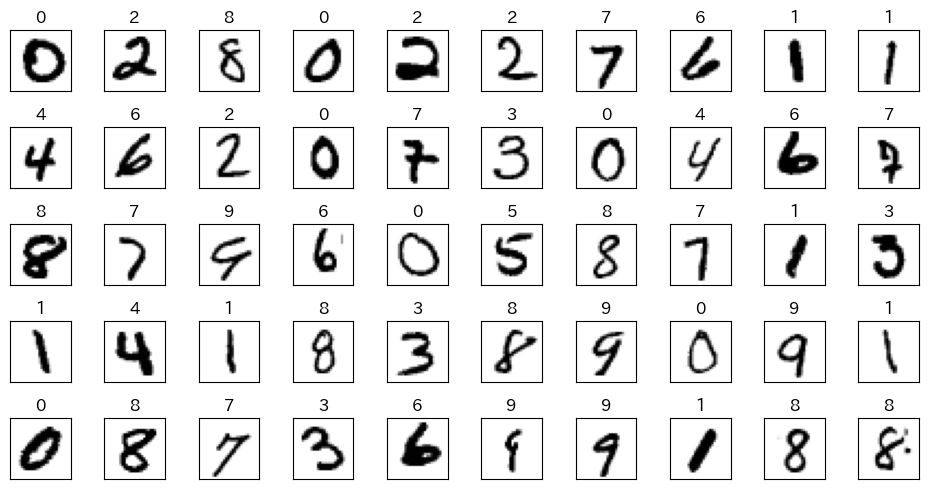

In [8]:
# イメージ表示
N1 = 10 # 横個数
N2 = 5  # 縦個数
N = N1 * N2 # 10*5 = 50個

# テストデータからランダムに50個のイメージを抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
indexes = np.random.choice(y_test_np.shape[0], N, replace=False)
x_selected = x_test_np[indexes]
y_selected = y_test_np[indexes]

# 50個の描画領域を設定
plt.figure(figsize=(N1, N2), tight_layout=True)
for i in range(N):
    # 個別イメージの描画位置指定
    ax = plt.subplot(N2, N1, i + 1)

    # イメージ表示
    ax.imshow(x_selected[i].reshape(28, 28), cmap='gray_r')

    # 正解ラベルを画像のタイトルとして表示
    ax.set_title(f'{int(y_selected[i]):d}', fontsize=12)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
create_pdf()
plt.show()

### データ加工

#### xの正規化

In [9]:
# xの正規化
x_train_norm_np = x_train_np / 255.0
x_test_norm_np = x_test_np / 255.0

# 先頭にダミー変数を追加
x_train_dum_np = np.insert(x_train_norm_np, 0, 1, axis=1)
x_test_dum_np = np.insert(x_test_norm_np, 0, 1, axis=1)

# shapeを表示
print(x_train_dum_np.shape, x_test_dum_np.shape)

# 結果の先頭要素を表示
print('x_train_dum_np[0]\n', x_train_dum_np[0])

(60000, 785) (10000, 785)
x_train_dum_np[0]
 [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.012 0.071 0.071
 0.071

#### 正解値のOne Hotベクトル化

In [10]:
# 正解値のOne Hotベクトル化

# OneHotEncoderのインポート
from sklearn.preprocessing import OneHotEncoder

# one hot encoderインスタンスの生成
ohe = OneHotEncoder(sparse_output=False,categories='auto')

# y_train_npのOne Hotベクトル化
y_train_ohe_np = ohe.fit_transform(y_train_np.reshape(-1, 1))

# y_test_npのOne Hotベクトル化
y_test_ohe_np = ohe.transform(y_test_np.reshape(-1, 1))

# 各変数のshape確認
print('y_train One Hot Vector化前', y_train_np.shape)
print('y_train One Hot Vector化後', y_train_ohe_np.shape)
print('y_test One Hot Vector化前', y_test_np.shape)
print('y_test One Hot Vector化後', y_test_ohe_np.shape)

y_train One Hot Vector化前 (60000,)
y_train One Hot Vector化後 (60000, 10)
y_test One Hot Vector化前 (10000,)
y_test One Hot Vector化後 (10000, 10)


## 10-8 プログラム実装(GPU利用)

#### Tensor型に変換

In [11]:
# Tensor型に変換

# PyTorchのインポート
import torch

# NumPy変数をTensor変数に変換
x_train = torch.Tensor(x_train_dum_np).float()
y_train = torch.Tensor(y_train_np).float()
y_train_ohe = torch.Tensor(y_train_ohe_np).float()
x_test = torch.Tensor(x_test_dum_np).float()
y_test = torch.Tensor(y_test_np).float()
y_test_ohe = torch.Tensor(y_test_ohe_np).float()

#### GPU 存在チェック

In [12]:
# GPU存在チェック

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


#### Tensor型データをGPUに転送

In [13]:
# Tensor型データをGPUに転送

# 訓練データをGPUに転送
x_train_gpu = x_train.to(device)
y_train_gpu = y_train.to(device)
y_train_ohe_gpu = y_train_ohe.to(device)

# テストデータをGPUに転送
x_test_gpu = x_test.to(device)
y_test_gpu = y_test.to(device)
y_test_ohe_gpu = y_test_ohe.to(device)

## 10-9 プログラム実装(ミニバッチ学習法・関数定義)

### ミニバッチ学習法

#### データローダーの定義

In [14]:
# データローダーの定義

# 必要ライブラリのインポート
from torch.utils.data import DataLoader, TensorDataset

# 0から19までの1次元配列をTensorDatasetとして定義
dataset = TensorDataset(torch.arange(20))

# datasetを5個ずつのグループで取り出すようにデータローダーを定義
loader = DataLoader(dataset, batch_size=5, shuffle=True)

#### データローダーの利用イメージ

In [15]:
# データローダーの利用イメージ
# 繰り返し回数(nb_epoch)=2で上記ローダを利用する

# 繰り返し回数の定義
nb_epoch = 2
for epoch in range(nb_epoch):
    print(f'epoch = {epoch}')

    # データローダーから5個ずつのグループにしたデータをbatchとして取得
    for batch in loader:
        print(batch[0].numpy())

epoch = 0
[ 3 14 19  0 15]
[10  5  6 18 13]
[ 7  4 17 16  1]
[ 9 12  2 11  8]
epoch = 1
[ 1 18  0 19  6]
[11 16  2  3  8]
[14 10 17  9 15]
[ 4  5  7 13 12]


### 関数定義

#### 汎用関数
シグモイド関数とsoftmax関数はPyTorch標準関数を利用

In [16]:
# 汎用関数

# PyTorch標準関数用ライブラリのインポート
import torch.nn as nn

# シグモイド関数の定義
sigmoid = nn.Sigmoid()

# softmax関数の定義
softmax = nn.Softmax(dim=1)

#### 交差エントロピー関数

In [17]:
# 交差エントロピー関数
# PyTorchの交差エントロピー関数はわかりにくいのでスクラッチで実装

def cross_entropy(yt_ohe, yp_ohe):
    return -torch.mean(torch.sum(yt_ohe * torch.log(yp_ohe), dim=1))

#### 評価関数
損失と精度を計算

In [18]:
# 評価関数
# 重み行列V, Wから学習中の損失と精度を計算

# accuracy_scoreは精度評価のための関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_ohe, x_dum, V, W):

    # テストデータに対して隠れ層の値を計算
    b_test = sigmoid(x_test @ V)

    # ダミー変数追加
    b1_test = torch.cat((x_dum, b_test), dim=1)

    # 予測値の計算(確率値)
    yp_test_ohe = softmax(b1_test @ W)

    # 予測クラス計算(0から9の整数)
    yp_test = torch.argmax(yp_test_ohe, dim=1)

    # 損失計算(item関数でスカラー化)
    loss = cross_entropy(y_test_ohe, yp_test_ohe).item()

    # 精度計算(item関数でスカラー化)
    score = (y_test == yp_test).float().mean().item()

    return score, loss

## 10-10 プログラム実装(学習その1)

### 学習

#### 学習関数1

In [21]:
# 学習関数1

def train_mlp(
    hidden_units=100, epochs=500, batch_size=500, alpha_np=0.01,
    his_unit=10):
    """
    2層（入力→Sigmoid→出力Softmax）の単純なMLPを、
    勾配降下法で学習する関数。
    返り値: (V, W, history[epoch, loss, acc])
    """
    # M: 訓練用系列データ総数
    # D: 入力データ次元数
    M, D  = x_train.shape
    # N: 分類クラス数
    N = y_train_ohe.shape[1]
    # 隠れ層のノード数
    H = hidden_units
    H1 = H + 1
    # 重み行列の初期設定
    np.random.seed(123)
    V_np = np.ones((D, H))
    W_np = np.ones((H1, N))
    # GPU転送
    alpha = torch.tensor(alpha_np).float().to(device)
    V = torch.tensor(V_np).float().to(device)
    W = torch.tensor(W_np).float().to(device)

    # 学習時のダミー変数
    x_dum_f = torch.ones((batch_size,1)).float().to(device)
    # 予測時のダミー変数
    x_dum_p = torch.ones((len(x_test),1)).float().to(device)

    # 評価結果記録用 (損失関数値と精度)
    history = np.zeros((0, 3))

    # データローダー初期化(ミニバッチ処理用)
    dataset = TensorDataset(torch.arange(M))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 繰り返し回数カウンタ初期化
    epoch = 0

    # 繰り返し計算
    while epoch < epochs:
        # 学習対象の選択(ミニバッチ学習法)
        for batch in loader:
            index = batch[0]
            x = x_train_gpu[index]
            yt = y_train_ohe_gpu[index]

            # 予測計算 (順伝播)
            a = x @ V
            b = sigmoid(a)
            b1 = torch.cat((x_dum_f, b), dim=1)
            u = b1 @ W
            yp = softmax(u)

            # 誤差計算 (逆伝播)
            yd = yp - yt
            bd = b * (1-b) * (yd @ W[1:].T)

            # 勾配計算
            grad_W = (b1.T @ yd) / batch_size
            grad_V = (x.T  @ bd) / batch_size

            # パラメータ更新
            W -= alpha * grad_W
            V -= alpha * grad_V

        score, loss = evaluate(x_test_gpu, y_test_gpu, y_test_ohe_gpu, x_dum_p, V, W)
        history = np.vstack((history, np.array([epoch, loss, score])))
        epoch = epoch + 1
        if (epoch-1) % his_unit == 0:
            print(f'epoch = {epoch-1} loss = {loss:.04f} score = {score:.04f}')

    return W, V, history

#### 学習

In [22]:
%%time
# 学習

# 学習パラメータ
hidden_units = 100  # 隠れ層サイズ
alpha_np = 0.01     # 学習率
batch_size = 500    # バッチサイズ
epochs = 500        # 繰り返し数
his_unit = 10       # 画面表示頻度

# 繰り返し処理
W, V, history1 = train_mlp(
    hidden_units=hidden_units,
    alpha_np=alpha_np, batch_size=batch_size,
    epochs=epochs, his_unit=his_unit)


epoch = 0 loss = 2.3013 score = 0.1135
epoch = 10 loss = 2.3014 score = 0.1135
epoch = 20 loss = 2.3016 score = 0.1135
epoch = 30 loss = 2.3014 score = 0.1135
epoch = 40 loss = 2.3016 score = 0.1135
epoch = 50 loss = 2.3013 score = 0.1135
epoch = 60 loss = 2.3016 score = 0.1135
epoch = 70 loss = 2.3014 score = 0.1135
epoch = 80 loss = 2.3014 score = 0.1135
epoch = 90 loss = 2.3013 score = 0.1135
epoch = 100 loss = 2.3013 score = 0.1135
epoch = 110 loss = 2.3012 score = 0.1135
epoch = 120 loss = 2.3013 score = 0.1135
epoch = 130 loss = 2.3016 score = 0.1135
epoch = 140 loss = 2.3015 score = 0.1135
epoch = 150 loss = 2.3014 score = 0.1135
epoch = 160 loss = 2.3018 score = 0.1135
epoch = 170 loss = 2.3016 score = 0.1135
epoch = 180 loss = 2.3019 score = 0.1135
epoch = 190 loss = 2.3014 score = 0.1135
epoch = 200 loss = 2.3021 score = 0.1135
epoch = 210 loss = 2.3014 score = 0.1135
epoch = 220 loss = 2.3013 score = 0.1135
epoch = 230 loss = 2.3018 score = 0.1028
epoch = 240 loss = 2.3014 s

### 結果分析

#### 損失と精度確認

In [23]:
# 損失と精度の確認
# 損失と精度の初期値と最終値を確認
print(f'初期状態: 関数:{history1[0,1]:.04f} \
精度:{history1[0,2]:.04f}')
print(f'最終状態: 関数:{history1[-1,1]:.04f} \
精度:{history1[-1,2]:.04f}')

初期状態: 関数:2.3013 精度:0.1135
最終状態: 関数:2.3019 精度:0.1135


#### 学習曲線(損失)

fig-10-03.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

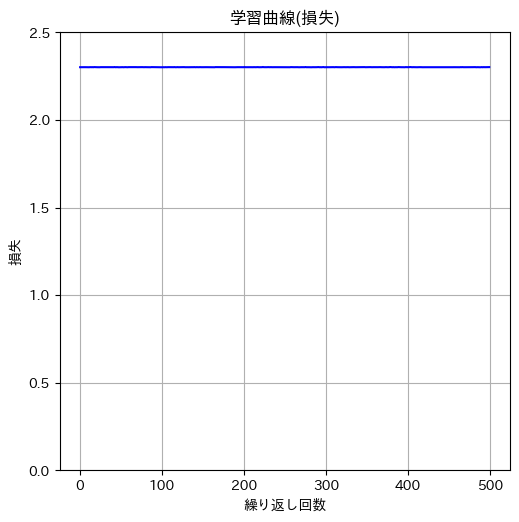

In [24]:
# 学習曲線(損失)

plt.figure(figsize=(6,6))
plt.plot(history1[:,0], history1[:,1], 'b')
plt.ylim(0,2.5)
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
create_pdf()
plt.show()

#### 学習曲線(精度)

fig-10-04.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

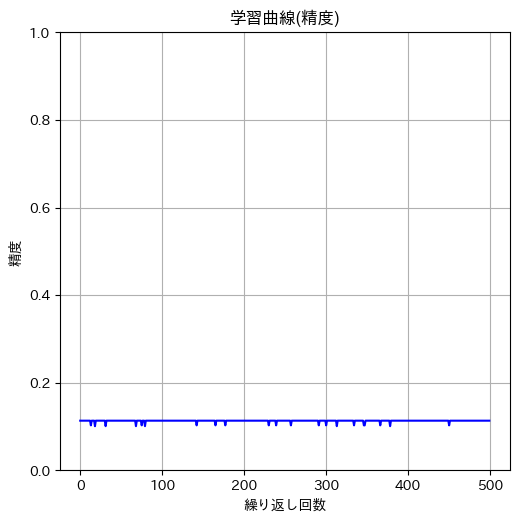

In [25]:
# 学習曲線(精度)

plt.figure(figsize=(6,6))
plt.plot(history1[:,0], history1[:,2], 'b')
plt.ylim(0,1)
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid()
create_pdf()
plt.show()

## 10-11 プログラム実装(学習その2)

### 学習( パラメータ初期値変更)

#### 重み行列初期化改訂版

In [26]:
# 重み行列初期化改訂版
hidden_units = 100  # 隠れ層サイズ
M, D  = x_train.shape
N = y_train_ohe.shape[1]
H = hidden_units
H1 = H + 1
np.random.seed(123)
V_np = np.random.randn(D, H) / np.sqrt(D / 2)
W_np = np.random.randn(H1, N) / np.sqrt(H1 / 2)

# 内容の一部確認
print(V_np[:2,:5])
print(W_np[:2,:5])

[[-0.055 0.050 0.014 -0.076 -0.029]
 [0.032 -0.100 0.036 0.131 -0.001]]
[[0.146 -0.104 0.056 0.003 -0.045]
 [-0.028 -0.114 0.106 0.080 0.014]]


#### 学習関数2

In [27]:
# 学習関数2

def train_mlp2(
    hidden_units=100, epochs=500, batch_size=500, alpha_np=0.01,
    his_unit=10):
    """
    2層（入力→Sigmoid→出力Softmax）の単純なMLPを、
    勾配降下法で学習する関数。
    返り値: (V, W, history[epoch, loss, acc])
    """
    # M: 訓練用系列データ総数
    # D: 入力データ次元数
    M, D  = x_train.shape
    # N: 分類クラス数
    N = y_train_ohe.shape[1]
    # 隠れ層のノード数
    H = hidden_units
    H1 = H + 1
    # 重み行列初期化改訂版
    np.random.seed(123)
    V_np = np.random.randn(D, H) / np.sqrt(D / 2)
    W_np = np.random.randn(H1, N) / np.sqrt(H1 / 2)
    # GPU転送
    alpha = torch.tensor(alpha_np).float().to(device)
    V = torch.tensor(V_np).float().to(device)
    W = torch.tensor(W_np).float().to(device)

    # 学習時のダミー変数
    x_dum_f = torch.ones((batch_size,1)).float().to(device)
    # 予測時のダミー変数
    x_dum_p = torch.ones((len(x_test),1)).float().to(device)

    # 評価結果記録用 (損失関数値と精度)
    history = np.zeros((0, 3))

    # データローダー初期化(ミニバッチ処理用)
    dataset = TensorDataset(torch.arange(M))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # 繰り返し回数カウンタ初期化
    epoch = 0

    # 繰り返し計算
    while epoch < epochs:
        # 学習対象の選択(ミニバッチ学習法)
        for batch in loader:
            index = batch[0]
            x = x_train_gpu[index]
            yt = y_train_ohe_gpu[index]

            # 予測計算 (順伝播)
            a = x @ V
            b = sigmoid(a)
            b1 = torch.cat((x_dum_f, b), dim=1)
            u = b1 @ W
            yp = softmax(u)

            # 誤差計算 (逆伝播)
            yd = yp - yt
            bd = b * (1-b) * (yd @ W[1:].T)

            # 勾配計算
            grad_W = (b1.T @ yd) / batch_size
            grad_V = (x.T  @ bd) / batch_size

            # パラメータ更新
            W -= alpha * grad_W
            V -= alpha * grad_V

        score, loss = evaluate(x_test_gpu, y_test_gpu, y_test_ohe_gpu, x_dum_p, V, W)
        history = np.vstack((history, np.array([epoch, loss, score])))
        epoch = epoch + 1
        if (epoch-1) % his_unit == 0:
            print(f'epoch = {epoch-1} loss = {loss:.04f} score = {score:.04f}')

    return W, V, history

#### 学習

In [28]:
%%time
# 学習

# 学習パラメータ
hidden_units = 100  # 隠れ層サイズ
alpha_np = 0.01     # 学習率
batch_size = 500    # バッチサイズ
epochs = 500        # 繰り返し数
his_unit = 10       # 画面表示頻度

# 繰り返し処理
W, V, history2 = train_mlp2(
    hidden_units=hidden_units,
    alpha_np=alpha_np, batch_size=batch_size,
    epochs=epochs, his_unit=his_unit)

epoch = 0 loss = 2.1365 score = 0.4259
epoch = 10 loss = 1.0970 score = 0.8176
epoch = 20 loss = 0.7191 score = 0.8565
epoch = 30 loss = 0.5694 score = 0.8745
epoch = 40 loss = 0.4916 score = 0.8838
epoch = 50 loss = 0.4441 score = 0.8898
epoch = 60 loss = 0.4119 score = 0.8941
epoch = 70 loss = 0.3886 score = 0.8978
epoch = 80 loss = 0.3708 score = 0.9010
epoch = 90 loss = 0.3568 score = 0.9049
epoch = 100 loss = 0.3453 score = 0.9070
epoch = 110 loss = 0.3356 score = 0.9085
epoch = 120 loss = 0.3274 score = 0.9098
epoch = 130 loss = 0.3202 score = 0.9110
epoch = 140 loss = 0.3139 score = 0.9122
epoch = 150 loss = 0.3083 score = 0.9131
epoch = 160 loss = 0.3032 score = 0.9144
epoch = 170 loss = 0.2985 score = 0.9155
epoch = 180 loss = 0.2941 score = 0.9167
epoch = 190 loss = 0.2902 score = 0.9167
epoch = 200 loss = 0.2865 score = 0.9173
epoch = 210 loss = 0.2830 score = 0.9182
epoch = 220 loss = 0.2796 score = 0.9194
epoch = 230 loss = 0.2765 score = 0.9201
epoch = 240 loss = 0.2734 s

### 結果分析

#### 損失と精度の確認

In [39]:
# 損失と精度の確認
# 損失と精度の初期値と最終値を確認
print(f'初期状態: 損失:{history2[0,1]:.04f} \
精度:{history2[0,2]:.04f}')
print(f'最終状態: 損失:{history2[-1,1]:.04f} \
精度:{history2[-1,2]:.04f}')

初期状態: 損失:2.1366 精度:0.4305
最終状態: 損失:0.2192 精度:0.9377


#### 学習曲線(損失)

fig-10-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

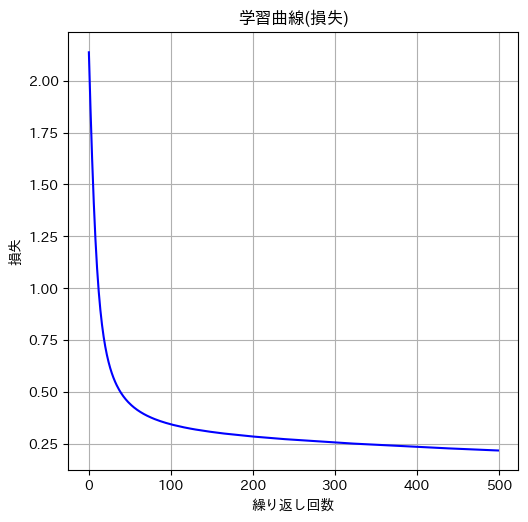

In [40]:
# 学習曲線(損失)

plt.figure(figsize=(6,6))
plt.plot(history2[:,0], history2[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
create_pdf()
plt.show()

#### 学習曲線(精度)

fig-10-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

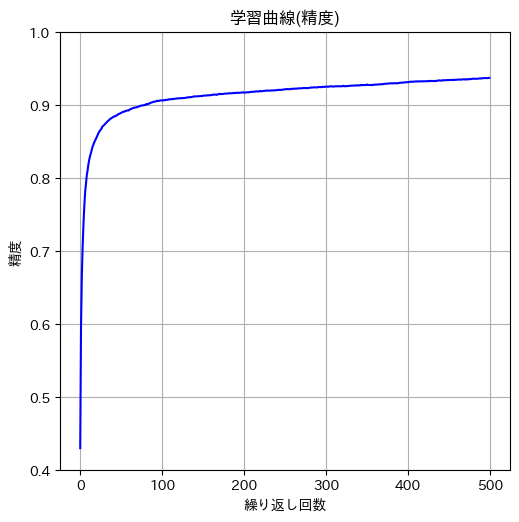

In [41]:
# 学習曲線(精度)

plt.figure(figsize=(6,6))
plt.plot(history2[:,0], history2[:,2], 'b')
plt.ylim(0.4,1)
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid()
create_pdf()
plt.show()

#### イメージで確認

fig-10-09.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

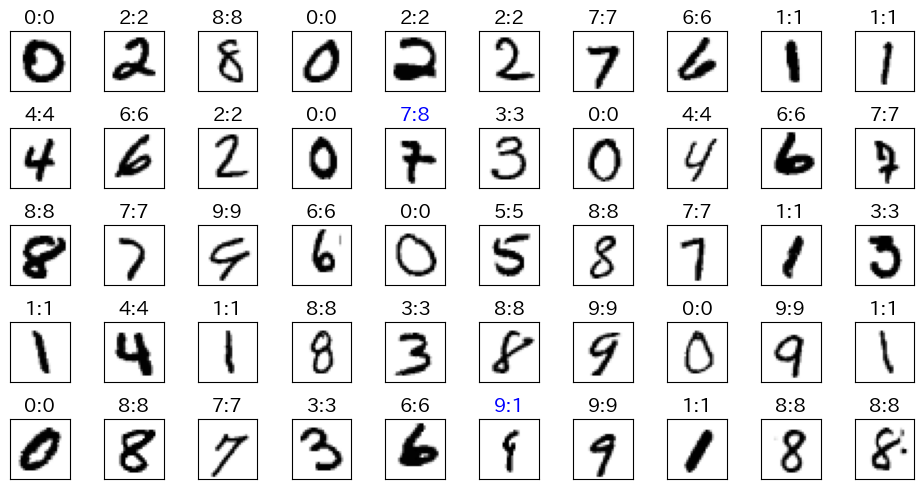

In [42]:
# イメージで確認

N1 = 10 # 横個数
N2 = 5  # 縦個数
N = N1 * N2 # 10*5 = 50個

# テストデータからランダムに50個のイメージを抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test_gpu[indexes]
x_selected_show = x_test_np[indexes]
y_selected = y_test_gpu[indexes]

# ダミー変数の準備
x_dum3 = torch.ones((N,1)).float().to(device)

# 予測値の計算
# テストデータに対して隠れ層の値を計算
b_test = sigmoid(x_selected @ V)

# ダミー変数追加
b1_test = torch.cat((x_dum3, b_test), dim=1)

# 予測値の計算(確率値)
yp_test_ohe = softmax(b1_test @ W)

# 予測クラス計算(0から9の整数)
yp_test = torch.argmax(yp_test_ohe, dim=1)

# 50個の描画領域を設定
plt.figure(figsize=(N1, N2), tight_layout=True)
for i in range(N):

    # 描画位置指定
    ax = plt.subplot(N2, N1, i + 1)

    # 画像イメージ表示
    ax.imshow(x_selected_show[i].reshape(28, 28),cmap='gray_r')

    # 正解ラベルと予測値
    true_label = int(y_selected[i])
    pred_label = int(yp_test[i])

    # タイトル色を条件で変更
    title_color = 'blue' if true_label != pred_label else 'black'

    # タイトル表示
    ax.set_title(f'{true_label}:{pred_label}', fontsize=14, color=title_color)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
create_pdf()
plt.show()

## 10-12 プログラム実装(学習その3)

### 学習

#### 学習

In [43]:
%%time
# 学習

# 学習パラメータ
hidden_units = 100  # 隠れ層サイズ
alpha_np = 0.01     # 学習率
#batch_size = 500   # バッチサイズ前回値
batch_size = 100    # バッチサイズ今回値
epochs = 500        # 繰り返し数
his_unit = 10       # 画面表示頻度

# 繰り返し処理
W, V, history3 = train_mlp2(
    hidden_units=hidden_units,
    alpha_np=alpha_np, batch_size=batch_size,
    epochs=epochs, his_unit=his_unit)


epoch = 0 loss = 1.6204 score = 0.7473
epoch = 10 loss = 0.4300 score = 0.8910
epoch = 20 loss = 0.3412 score = 0.9074
epoch = 30 loss = 0.3064 score = 0.9133
epoch = 40 loss = 0.2851 score = 0.9176
epoch = 50 loss = 0.2695 score = 0.9225
epoch = 60 loss = 0.2567 score = 0.9259
epoch = 70 loss = 0.2456 score = 0.9284
epoch = 80 loss = 0.2357 score = 0.9325
epoch = 90 loss = 0.2266 score = 0.9347
epoch = 100 loss = 0.2185 score = 0.9384
epoch = 110 loss = 0.2108 score = 0.9396
epoch = 120 loss = 0.2040 score = 0.9417
epoch = 130 loss = 0.1975 score = 0.9436
epoch = 140 loss = 0.1916 score = 0.9459
epoch = 150 loss = 0.1861 score = 0.9477
epoch = 160 loss = 0.1810 score = 0.9480
epoch = 170 loss = 0.1761 score = 0.9492
epoch = 180 loss = 0.1717 score = 0.9507
epoch = 190 loss = 0.1676 score = 0.9522
epoch = 200 loss = 0.1635 score = 0.9533
epoch = 210 loss = 0.1598 score = 0.9544
epoch = 220 loss = 0.1564 score = 0.9551
epoch = 230 loss = 0.1529 score = 0.9561
epoch = 240 loss = 0.1497 s

### 結果分析

#### 損失と精度の確認

In [44]:
# 損失と精度の確認
# 損失と精度の初期値と最終値を確認
print(f'初期状態: 損失:{history3[0,1]:.04f} \
精度:{history3[0,2]:.04f}')
print(f'最終状態: 損失:{history3[-1,1]:.04f} \
精度:{history3[-1,2]:.04f}')

初期状態: 損失:1.6204 精度:0.7473
最終状態: 損失:0.1023 精度:0.9702


#### 学習曲線(損失)

fig-10-10.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

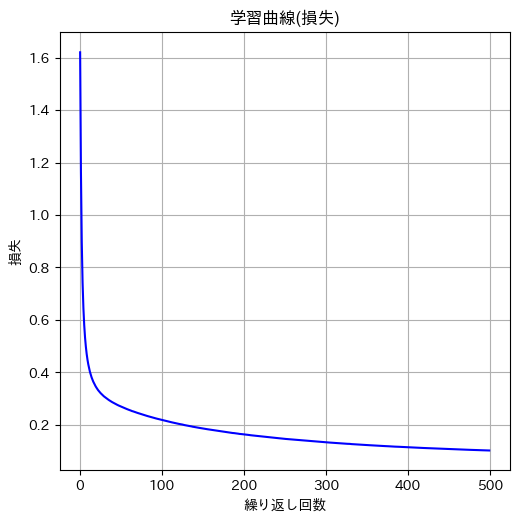

In [45]:
# 学習曲線(損失)

plt.figure(figsize=(6,6))
plt.plot(history3[:,0], history3[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
create_pdf()
plt.show()

#### 学習曲線(精度)

fig-10-11.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

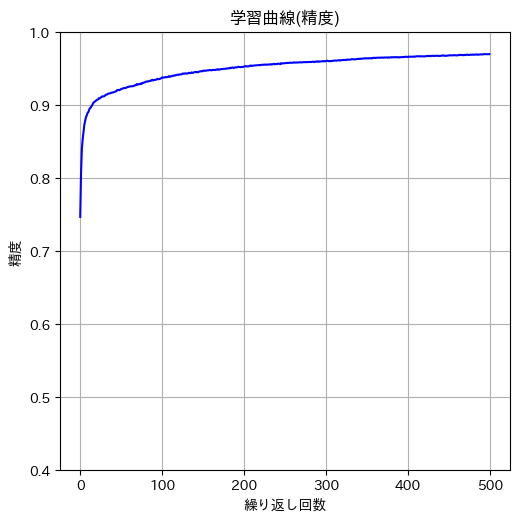

In [46]:
# 学習曲線(精度)

plt.figure(figsize=(6,6))
plt.plot(history3[:,0], history3[:,2], 'b')
plt.ylim(0.4,1)
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid()
create_pdf()
plt.show()

#### イメージで確認

fig-10-12.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

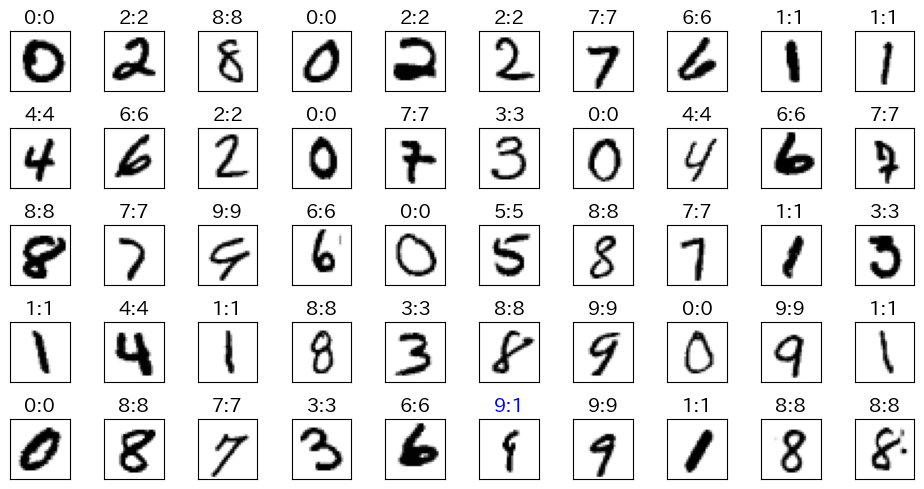

In [47]:
# イメージで確認

N1 = 10 # 横個数
N2 = 5  # 縦個数
N = N1 * N2 # 10*5 = 50個

# テストデータからランダムに50個のイメージを抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test_gpu[indexes]
x_selected_show = x_test_np[indexes]
y_selected = y_test_gpu[indexes]

# ダミー変数の準備
x_dum3 = torch.ones((N,1)).float().to(device)

# 予測値の計算
# テストデータに対して隠れ層の値を計算
b_test = sigmoid(x_selected @ V)

# ダミー変数追加
b1_test = torch.cat((x_dum3, b_test), dim=1)

# 予測値の計算(確率値)
yp_test_ohe = softmax(b1_test @ W)

# 予測クラス計算(0から9の整数)
yp_test = torch.argmax(yp_test_ohe, dim=1)

# 50個の描画領域を設定
plt.figure(figsize=(N1, N2), tight_layout=True)
for i in range(N):

    # 描画位置指定
    ax = plt.subplot(N2, N1, i + 1)

    # 画像イメージ表示
    ax.imshow(x_selected_show[i].reshape(28, 28),cmap='gray_r')

    # 正解ラベルと予測値
    true_label = int(y_selected[i])
    pred_label = int(yp_test[i])

    # タイトル色を条件で変更
    title_color = 'blue' if true_label != pred_label else 'black'

    # タイトル表示
    ax.set_title(f'{true_label}:{pred_label}', fontsize=14, color=title_color)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
create_pdf()
plt.show()

## 10-13 プログラム実装(学習その4)

### 関数定義

#### evaluate2関数
隠れ層2層向けの評価関数

In [29]:
# evaluate2関数
def evaluate2(x_test, y_test, y_test_ohe, x_dum_p, U, V, W):

    # テストデータに対して隠れ層の値を計算
    b_test = sigmoid(x_test @ U)

    # ダミー変数追加
    b1_test = torch.cat((x_dum_p, b_test), dim=1)

    d_test = sigmoid(b1_test @ V)

    # ダミー変数追加
    d1_test = torch.cat((x_dum_p, d_test), dim=1)

    # 予測値算出
    yp_test_ohe = softmax(d1_test @ W)

    # ラベル値算出
    yp_test = torch.argmax(yp_test_ohe, dim=1)

    # 損失計算(item関数でスカラー化)
    loss = cross_entropy(y_test_ohe, yp_test_ohe).item()

    # 精度計算(item関数でスカラー化)
    score = (y_test == yp_test).float().mean().item()

    return score, loss

### 学習(隠れ層2層化)

#### 学習関数3

In [31]:
def train_mlp3(
    hidden_units=100, epochs=500, batch_size=500, alpha_np=0.01,
    his_unit=10):
    """
    3層（入力→Sigmoid→出力Softmax）の単純なMLPを、
    勾配降下法で学習する関数。
    返り値: (U, V, W, history[epoch, loss, acc])
    """
    # M: 訓練用系列データ総数
    # D: 入力データ次元数
    M, D  = x_train.shape
    # N: 分類クラス数
    N = y_train_ohe.shape[1]
    # 隠れ層のノード数
    H = hidden_units
    H1 = H + 1
    # 重み行列初期化改訂版
    np.random.seed(123)
    U_np = np.random.randn(D, H) / np.sqrt(D / 2)
    V_np = np.random.randn(H1, H) / np.sqrt(H1 / 2)
    W_np = np.random.randn(H1, N) / np.sqrt(H1 / 2)
    # GPU転送
    alpha = torch.tensor(alpha_np).float().to(device)
    U = torch.tensor(U_np).float().to(device)
    V = torch.tensor(V_np).float().to(device)
    W = torch.tensor(W_np).float().to(device)

    # 学習時のダミー変数
    x_dum_f = torch.ones((batch_size,1)).float().to(device)
    # 予測時のダミー変数
    x_dum_p = torch.ones((len(x_test),1)).float().to(device)

    # 評価結果記録用 (損失関数値と精度)
    history = np.zeros((0, 3))

    # データローダー初期化(ミニバッチ処理用)
    dataset = TensorDataset(torch.arange(M))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # 繰り返し回数カウンタ初期化
    epoch = 0

    # 繰り返し計算
    while epoch < epochs:
        # 学習対象の選択(ミニバッチ学習法)
        for batch in loader:
            index = batch[0]
            x = x_train_gpu[index]
            yt = y_train_ohe_gpu[index]

            # 予測計算 (順伝播)
            a = x @ U
            b = sigmoid(a)
            b1 = torch.cat((x_dum_f, b), dim=1)
            c = b1 @ V
            d = sigmoid(c)
            d1 = torch.cat((x_dum_f, d), dim=1)
            u = d1 @ W
            yp = softmax(u)

            # 誤差計算 (逆伝播)
            yd = yp - yt
            dd = d * (1-d) * torch.tensor(yd @ W[1:].T)
            bd = b * (1-b) * torch.tensor(dd @ V[1:].T)

            # 勾配計算
            grad_W = (d1.T @ yd) / batch_size
            grad_V = (b1.T  @ dd) / batch_size
            grad_U = (x.T @ bd) / batch_size

            # パラメータ更新
            W -= alpha * grad_W
            V -= alpha * grad_V
            U -= alpha * grad_U

        score, loss = evaluate2(x_test_gpu, y_test_gpu, y_test_ohe_gpu,
                                x_dum_p, U, V, W)
        history = np.vstack((history, np.array([epoch, loss, score])))
        epoch = epoch + 1
        if (epoch-1) % his_unit == 0:
            print(f'epoch = {epoch-1} loss = {loss:.04f} score = {score:.04f}')
    return U, W, V, history

#### 学習

In [34]:
%%time
# 学習

# 学習パラメータ
hidden_units = 100  # 隠れ層サイズ
alpha_np = 0.01     # 学習率
#batch_size = 500   # バッチサイズ前回値
batch_size = 100    # バッチサイズ今回値
epochs = 1000        # 繰り返し数
his_unit = 10       # 画面表示頻度

# 繰り返し処理
U, W, V, history4 = train_mlp3(
    hidden_units=hidden_units,
    alpha_np=alpha_np, batch_size=batch_size,
    epochs=epochs, his_unit=his_unit)


epoch = 0 loss = 2.1977 score = 0.4141
epoch = 10 loss = 0.6522 score = 0.8432
epoch = 20 loss = 0.4099 score = 0.8923
epoch = 30 loss = 0.3405 score = 0.9065
epoch = 40 loss = 0.3075 score = 0.9123
epoch = 50 loss = 0.2859 score = 0.9192
epoch = 60 loss = 0.2692 score = 0.9247
epoch = 70 loss = 0.2550 score = 0.9277
epoch = 80 loss = 0.2429 score = 0.9299
epoch = 90 loss = 0.2318 score = 0.9339
epoch = 100 loss = 0.2216 score = 0.9369
epoch = 110 loss = 0.2123 score = 0.9393
epoch = 120 loss = 0.2033 score = 0.9413
epoch = 130 loss = 0.1951 score = 0.9435
epoch = 140 loss = 0.1869 score = 0.9458
epoch = 150 loss = 0.1796 score = 0.9479
epoch = 160 loss = 0.1728 score = 0.9501
epoch = 170 loss = 0.1671 score = 0.9513
epoch = 180 loss = 0.1607 score = 0.9523
epoch = 190 loss = 0.1558 score = 0.9532
epoch = 200 loss = 0.1505 score = 0.9543
epoch = 210 loss = 0.1458 score = 0.9556
epoch = 220 loss = 0.1418 score = 0.9570
epoch = 230 loss = 0.1377 score = 0.9590
epoch = 240 loss = 0.1339 s

### 結果分析その4

#### 損失と精度の確認

In [37]:
# 損失と精度の確認
# 損失と精度の初期値と最終値を確認
print(f'初期状態: 損失:{history4[0,1]:.04f} \
精度:{history4[0,2]:.04f}')
print(f'最終状態: 損失:{history4[-1,1]:.04f} \
精度:{history4[-1,2]:.04f}')

初期状態: 損失:2.1977 精度:0.4141
最終状態: 損失:0.0710 精度:0.9778


#### 学習曲線(損失)

fig-10-06.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

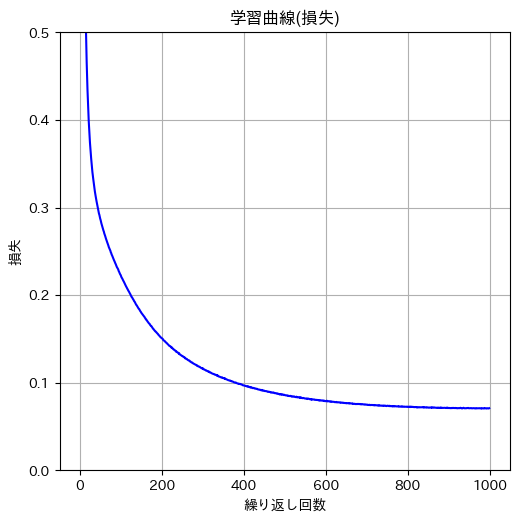

In [39]:
# 学習曲線(損失)

plt.figure(figsize=(6,6))
plt.plot(history4[:,0], history4[:,1], 'b')
plt.ylim(0,0.5)
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
create_pdf()
plt.show()

#### 学習曲線(精度)

fig-10-07.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

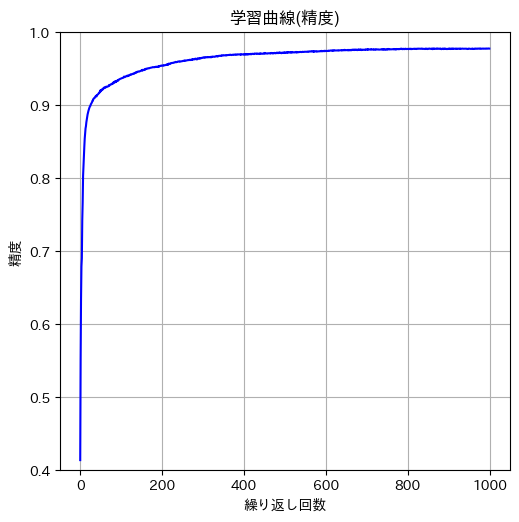

In [40]:
# 学習曲線(精度)

plt.figure(figsize=(6,6))
plt.plot(history4[:,0], history4[:,2], 'b')
plt.ylim(0.4,1)
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid()
create_pdf()
plt.show()

#### イメージで確認

fig-10-08.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

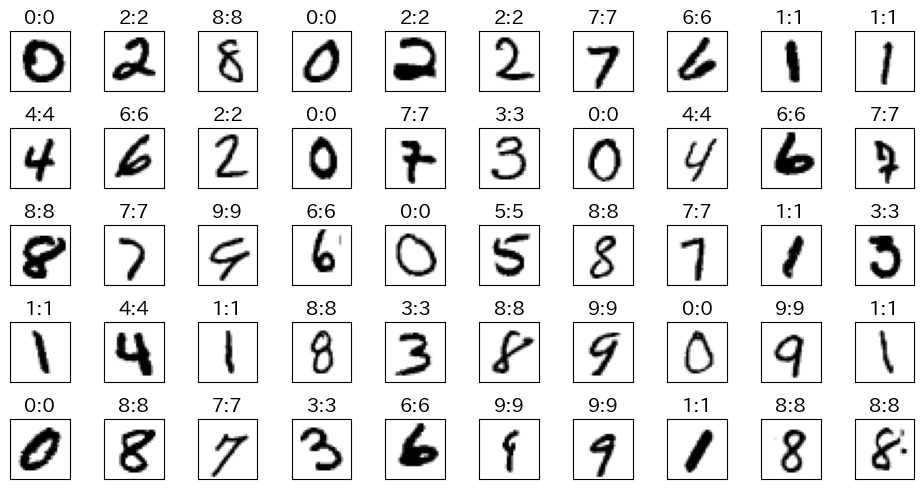

In [41]:
# イメージで確認

N1 = 10 # 横個数
N2 = 5  # 縦個数
N = N1 * N2 # 10*5 = 50個

# テストデータからランダムに50個のイメージを抽出
# 再現性があるようにseed値をセットしておく
np.random.seed(12)
indexes = np.random.choice(y_test.shape[0], N, replace=False)
x_selected = x_test_gpu[indexes]
x_selected_show = x_test_np[indexes]
y_selected = y_test_gpu[indexes]

# ダミー変数の準備
x_dum_i = torch.ones((N,1)).float().to(device)

# 予測値の計算(隠れ層1層目)
b_test = sigmoid(x_selected @ U)

# ダミー変数追加
b1_test = torch.cat((x_dum_i, b_test), dim=1)

# 予測値の計算(隠れ層2層目)
d_test = sigmoid(b1_test @ V)

# ダミー変数追加
d1_test = torch.cat((x_dum_i, d_test), dim=1)

# 予測値の計算(確率値)
yp_test_ohe = softmax(d1_test @ W)

# 予測クラス計算(0から9の整数)
yp_test = torch.argmax(yp_test_ohe, dim=1)

# 50個の描画領域を設定
plt.figure(figsize=(N1, N2), tight_layout=True)
for i in range(N):

    # 描画位置指定
    ax = plt.subplot(N2, N1, i + 1)

    # 画像イメージ表示
    ax.imshow(x_selected_show[i].reshape(28, 28),cmap='gray_r')

    # 正解ラベルと予測値
    true_label = int(y_selected[i])
    pred_label = int(yp_test[i])

    # タイトル色を条件で変更
    title_color = 'blue' if true_label != pred_label else 'black'

    # タイトル表示
    ax.set_title(f'{true_label}:{pred_label}', fontsize=14, color=title_color)

    # 軸ラベル非表示
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
create_pdf()
plt.show()


### バージョン確認

In [ ]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions